In [1]:
import torch
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.plot import pltCL, pltPhase
from copy import deepcopy

### plant model

In [2]:
# Double integrator parameters
nx = 2
nu = 1
nref = 1
A = torch.tensor([[1.2, 1.0],
                  [0.0, 1.0]])
B = torch.tensor([[1.0],
                  [0.5]])

# linear state space model
xnext = lambda x, u: x @ A.T + u @ B.T
double_integrator = Node(xnext, ['X', 'U'], ['X'], name='integrator')

### training data

In [3]:
# prediction horizon
nsteps = 20

# number of simulations
nsim = 3333
# batch size for data loader
batch_size = nsim
do_shuffle=False

x_range          = torch.distributions.Uniform(-3., 3.)
samples_train = {
    "X": x_range.sample((nsim, 1, nx)),#.repeat(1, 1, 1),
    "Xr": x_range.sample((nsim,1, 1)).repeat(1, nsteps+1, 1),
}
samples_dev = {
    "X": x_range.sample((nsim, 1, nx)),#.repeat(1, 1, 1),
    "Xr": x_range.sample((nsim, 1, 1)).repeat(1, nsteps+1, 1),
}
samples_test = {
    "X": x_range.sample((nsim, 1, nx)),#.repeat(1, 1, 1),
    "Xr": x_range.sample((nsim, 1, 1)).repeat(1, nsteps+1, 1),
}

# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data = DictDataset(samples_dev, name='dev')
test_data = DictDataset(samples_test, name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=0,
                                           collate_fn=train_data.collate_fn, shuffle=do_shuffle)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size, num_workers=0,
                                         collate_fn=dev_data.collate_fn, shuffle=do_shuffle)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=0,
                                         collate_fn=test_data.collate_fn, shuffle=do_shuffle)

### control policy

In [4]:
# neural control policy
mlp = blocks.MLP(nx+nref, nu, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[20, 20, 20, 20])
policy = Node(mlp, ['X', 'Xr'], ['U'], name='policy')

### closed loop system

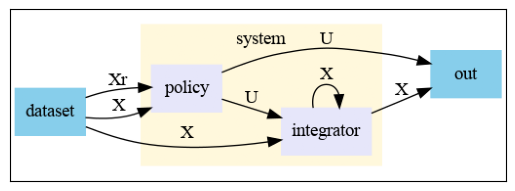

In [5]:
# closed loop system definition
cl_system1 = System([policy, double_integrator])
cl_system1.show()
cl_system2 = deepcopy(cl_system1)
cl_system3 = deepcopy(cl_system1)


### constraints and loss definitions

In [6]:
# Define optimization problem
u = variable('U')
x = variable('X')
xr = variable('Xr')
action_loss = 0.001 * (u == 0.)^2  # control penalty
regulation_loss = 10. * (x[:,:,0]==xr[:,:,0])^2  # target position

# 3 variant of  loss on control action
loss1 = PenaltyLoss([action_loss, regulation_loss], [])
action_loss = 1 * (u == 0.)^2  # control penalty
loss2 = PenaltyLoss([action_loss, regulation_loss], [])
action_loss = 10 * (u == 0.)^2  # control penalty
loss3 = PenaltyLoss([action_loss, regulation_loss], [])

problem1 = Problem([cl_system1], loss1)
problem2 = Problem([cl_system2], loss2)
problem3 = Problem([cl_system3], loss3)

optimizer1 = torch.optim.AdamW(problem1.parameters(), lr=0.001)
optimizer2 = torch.optim.AdamW(problem2.parameters(), lr=0.001)
optimizer3 = torch.optim.AdamW(problem3.parameters(), lr=0.001)

### training

In [7]:
trainer1 = Trainer(
    problem1,
    train_loader,
    dev_loader,
    test_loader,
    optimizer=optimizer1,
    epochs=400,
    train_metric="train_loss",
    dev_metric="dev_loss",
    eval_metric='dev_loss',
    warmup=400,
)
trainer2 = Trainer(
    problem2,
    train_loader,
    dev_loader,
    test_loader,
    optimizer=optimizer2,
    epochs=400,
    train_metric="train_loss",
    dev_metric="dev_loss",
    eval_metric='dev_loss',
    warmup=400,
)
trainer3 = Trainer(
    problem3,
    train_loader,
    dev_loader,
    test_loader,
    optimizer=optimizer3,
    epochs=400,
    train_metric="train_loss",
    dev_metric="dev_loss",
    eval_metric='dev_loss',
    warmup=400,
)

cl_system1.nsteps = nsteps
cl_system2.nsteps = nsteps
cl_system3.nsteps = nsteps
best_model1 = trainer1.train()
best_model2 = trainer2.train()
best_model3 = trainer3.train()

/home/martgro1/pot_neuromancer_for_ocp/.venv/lib/python3.10/site-packages/neuromancer/constraint.py:172: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3333, 20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)
/home/martgro1/pot_neuromancer_for_ocp/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:829: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


epoch: 0  train_loss: 202200.015625
epoch: 1  train_loss: 191498.4375
epoch: 2  train_loss: 181771.3125
epoch: 3  train_loss: 172687.21875
epoch: 4  train_loss: 164112.59375
epoch: 5  train_loss: 156000.53125
epoch: 6  train_loss: 148680.375
epoch: 7  train_loss: 141688.625
epoch: 8  train_loss: 134851.296875
epoch: 9  train_loss: 128095.875
epoch: 10  train_loss: 121429.171875
epoch: 11  train_loss: 114854.84375
epoch: 12  train_loss: 108353.0390625
epoch: 13  train_loss: 101881.171875
epoch: 14  train_loss: 95497.671875
epoch: 15  train_loss: 89335.1171875
epoch: 16  train_loss: 83332.0234375
epoch: 17  train_loss: 77388.0390625
epoch: 18  train_loss: 71522.3046875
epoch: 19  train_loss: 65759.1484375
epoch: 20  train_loss: 60128.6875
epoch: 21  train_loss: 54661.1328125
epoch: 22  train_loss: 49395.97265625
epoch: 23  train_loss: 44372.484375
epoch: 24  train_loss: 39612.5703125
epoch: 25  train_loss: 35133.51953125
epoch: 26  train_loss: 30950.224609375
epoch: 27  train_loss: 27074

### evaluate model performance on test data

load test data

In [8]:
test_data = next(iter(test_loader))
print('X:', test_data['X'][0])
print('Xr:', test_data['Xr'][0][0])

X: tensor([[ 2.4495, -0.0295]])
Xr: tensor([-2.6359])


load best model parameters

In [9]:
# Test best model with prediction horizon of 50
problem1.load_state_dict(best_model1)
problem2.load_state_dict(best_model2)
problem3.load_state_dict(best_model3)

trajectories1 = cl_system1(test_data)
trajectories2 = cl_system2(test_data)
trajectories3 = cl_system3(test_data)


In [10]:
trajectories1['X'].shape

torch.Size([3333, 21, 2])

plot results

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def get_traj(trajectories,nn,nsteps):
    x=trajectories['X'][nn,:,:].detach().reshape(nsteps+1, 2)
    xr=trajectories['Xr'][nn,0].detach()*np.ones_like(x[:,0])
    u=trajectories['U'][nn,:,:].detach().reshape(nsteps, 1)
    return x,xr,u

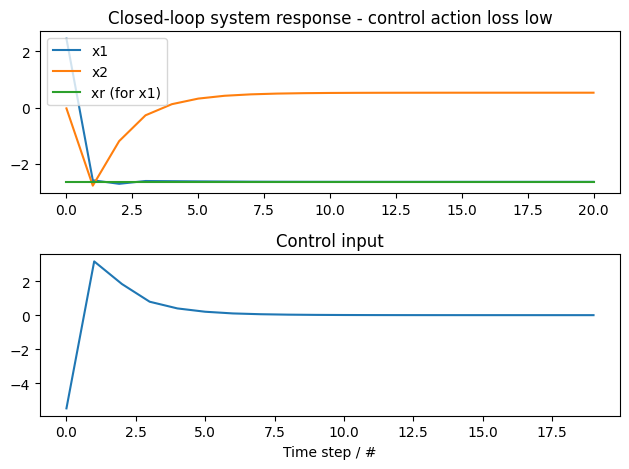

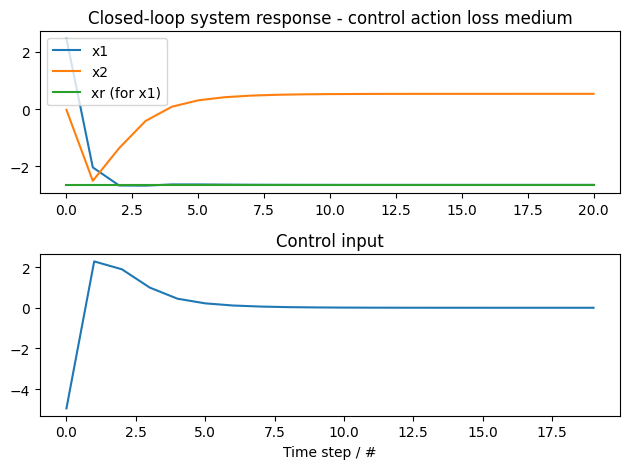

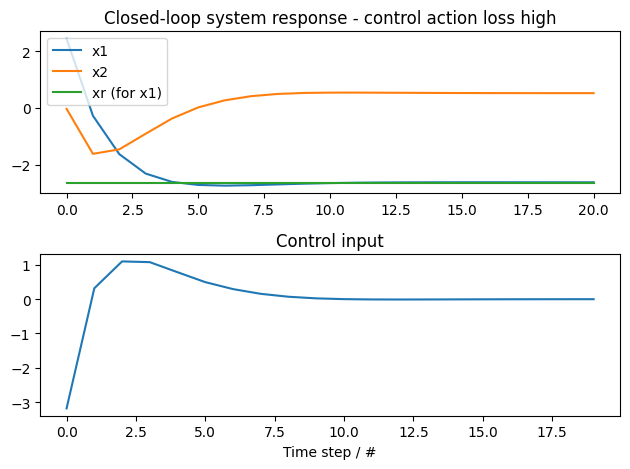

In [ ]:
for nn in range(0,1):
    plt.figure()
    plt.subplot(2,1,1)
    x,xr,u = get_traj(trajectories1,nn,nsteps)
    plt.plot(x)
    plt.plot(xr)
    plt.legend(('x1','x2','xr (for x1)'))
    plt.title('Closed-loop system response - control action loss low')
    plt.subplot(2,1,2)
    plt.plot(u)
    plt.title('Control input')
    plt.xlabel('Time step / #')
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.subplot(2,1,1)
    x,xr,u = get_traj(trajectories2,nn,nsteps)
    plt.plot(x)
    plt.plot(xr)
    plt.legend(('x1','x2','xr (for x1)'))
    plt.title('Closed-loop system response - control action loss medium')
    plt.subplot(2,1,2)
    plt.plot(u)
    plt.title('Control input')
    plt.xlabel('Time step / #')
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.subplot(2,1,1)
    x,xr,u = get_traj(trajectories3,nn,nsteps)
    plt.plot(x)
    plt.plot(xr)
    plt.legend(('x1','x2','xr (for x1)'))
    plt.title('Closed-loop system response - control action loss high')
    plt.subplot(2,1,2)
    plt.plot(u)
    plt.title('Control input')
    plt.xlabel('Time step / #')
    plt.tight_layout()
    plt.show()

Xr= tensor(-2.6359)


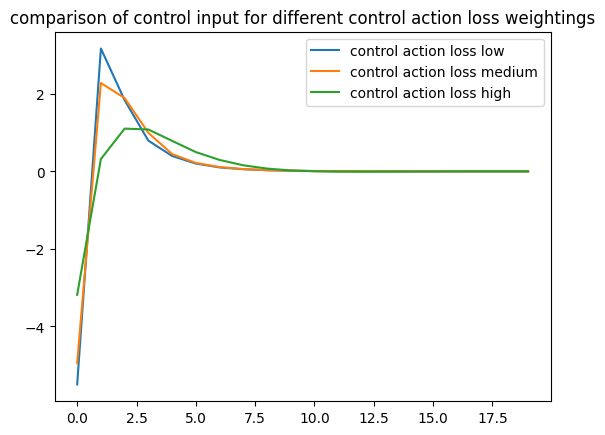

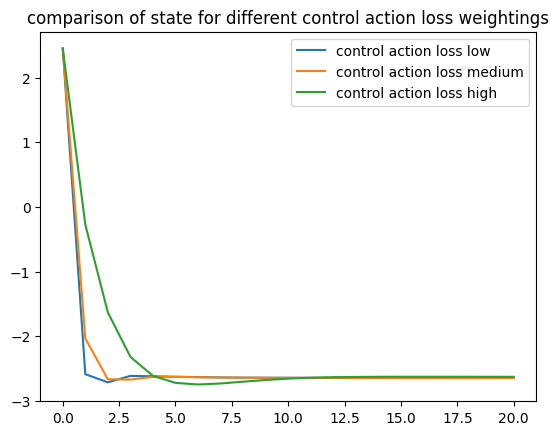

In [24]:
plt.figure()
x,xr,u = get_traj(trajectories1,nn,nsteps)
plt.plot(u)
x,xr,u = get_traj(trajectories2,nn,nsteps)
plt.plot(u)
x,xr,u = get_traj(trajectories3,nn,nsteps)
plt.plot(u)
plt.legend(('control action loss low','control action loss medium','control action loss high'))
plt.title('comparison of control input for different control action loss weightings')

plt.figure()
x,xr,u = get_traj(trajectories1,nn,nsteps)
plt.plot(x[:,0])
x,xr,u = get_traj(trajectories2,nn,nsteps)
plt.plot(x[:,0])
x,xr,u = get_traj(trajectories3,nn,nsteps)
plt.plot(x[:,0])
plt.legend(('control action loss low','control action loss medium','control action loss high'))
plt.title('comparison of state for different control action loss weightings')
print('Xr=',xr[0])